<a href="https://colab.research.google.com/github/smf-9000/Text-Intent-Classification/blob/main/Text_Classification_LSTM_subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00570/clinc150_uci.zip

--2021-07-10 15:29:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00570/clinc150_uci.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1053960 (1.0M) [application/x-httpd-php]
Saving to: ‘clinc150_uci.zip’

clinc150_uci.zip    100%[===================>]   1.00M  5.68MB/s    in 0.2s    

2021-07-10 15:29:11 (5.68 MB/s) - ‘clinc150_uci.zip’ saved [1053960/1053960]



In [ ]:
!unzip /content/clinc150_uci.zip -d /content

Archive:  /content/clinc150_uci.zip
   creating: /content/clinc150_uci/
  inflating: /content/clinc150_uci/data_small.json  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/clinc150_uci/
  inflating: /content/__MACOSX/clinc150_uci/._data_small.json  
  inflating: /content/clinc150_uci/meta.txt  
  inflating: /content/__MACOSX/clinc150_uci/._meta.txt  
  inflating: /content/clinc150_uci/LICENSE  
  inflating: /content/clinc150_uci/data_oos_plus.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_oos_plus.json  
  inflating: /content/clinc150_uci/data_imbalanced.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_imbalanced.json  
  inflating: /content/clinc150_uci/data_full.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_full.json  


In [ ]:
import pandas as pd
import json

In [ ]:
with open('/content/clinc150_uci/data_full.json', 'r') as file:
  data_JSON = file.read()
  data = json.loads(data_JSON)
  
sentences = []
labels = []
CL = {}
for tajp in ['train', 'test', 'val']:
  for s, c in data[tajp]:
    if c not in CL:
      CL[c] = len(CL.keys())
    sentences.append(s)
    labels.append(CL[c])

In [ ]:
list(zip(sentences, labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
vocab_size = 5000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=10)

for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [ ]:
print(sentences[5])

[11, 12, 2, 728, 1435, 3298, 790, 852, 15, 1925, 3908, 4538]


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

max_length = 100

sequences_padded = pad_sequences(sentences, maxlen=max_length, padding='post', truncating='post')

training_sequences, testing_sequences, training_labels, testing_labels = train_test_split(sequences_padded, labels, test_size=0.2, random_state=1)

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



```
# ----------------------------------------------------------------------
```



In [ ]:
embedding_dim = 64
num_epochs = 30

class DCLIN(tf.keras.Model):
    
    def __init__(self):
        super(DCLIN, self).__init__(name='model_i')
        
        self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.pool_1 = layers.GlobalAveragePooling1D()
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.pool_1(x)
        x = self.dense_1(x)
        output = self.dense_last(x)
        return output

model = DCLIN()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
563/563 [==============================] - 7s 6ms/step - loss: 4.9960 - sparse_categorical_accuracy: 0.0129 - val_loss: 4.8645 - val_sparse_categorical_accuracy: 0.0236
Epoch 2/30
563/563 [==============================] - 3s 6ms/step - loss: 4.0705 - sparse_categorical_accuracy: 0.0819 - val_loss: 3.5057 - val_sparse_categorical_accuracy: 0.1589
Epoch 3/30
563/563 [==============================] - 3s 5ms/step - loss: 3.0853 - sparse_categorical_accuracy: 0.2214 - val_loss: 2.8178 - val_sparse_categorical_accuracy: 0.2869
Epoch 4/30
563/563 [==============================] - 3s 6ms/step - loss: 2.4912 - sparse_categorical_accuracy: 0.3623 - val_loss: 2.3750 - val_sparse_categorical_accuracy: 0.3922
Epoch 5/30
563/563 [==============================] - 3s 5ms/step - loss: 2.0111 - sparse_categorical_accuracy: 0.4956 - val_loss: 1.9689 - val_sparse_categorical_accuracy: 0.4951
Epoch 6/30
563/563 [==============================] - 3s 6ms/step - loss: 1.6147 - sparse_categorica

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

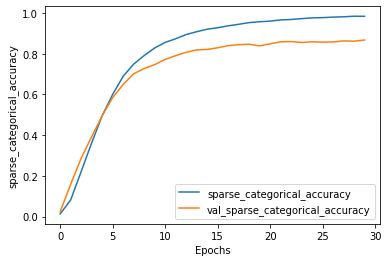

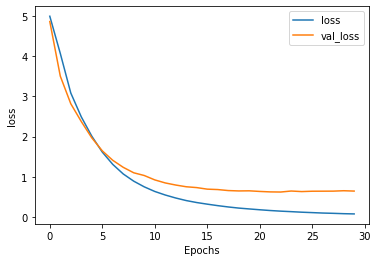

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [ ]:
class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_ii')
        
        self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256))
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
563/563 [==============================] - 17s 19ms/step - loss: 3.7339 - sparse_categorical_accuracy: 0.1267 - val_loss: 2.1888 - val_sparse_categorical_accuracy: 0.3771
Epoch 2/30
563/563 [==============================] - 10s 17ms/step - loss: 1.5855 - sparse_categorical_accuracy: 0.5342 - val_loss: 1.0596 - val_sparse_categorical_accuracy: 0.7240
Epoch 3/30
563/563 [==============================] - 10s 17ms/step - loss: 0.7700 - sparse_categorical_accuracy: 0.7822 - val_loss: 0.7601 - val_sparse_categorical_accuracy: 0.8098
Epoch 4/30
563/563 [==============================] - 10s 17ms/step - loss: 0.4843 - sparse_categorical_accuracy: 0.8620 - val_loss: 0.6753 - val_sparse_categorical_accuracy: 0.8400
Epoch 5/30
563/563 [==============================] - 10s 17ms/step - loss: 0.3291 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.6328 - val_sparse_categorical_accuracy: 0.8549
Epoch 6/30
563/563 [==============================] - 10s 17ms/step - loss: 0.2491 - spars

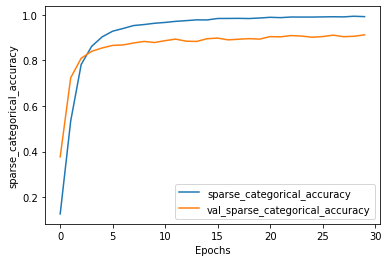

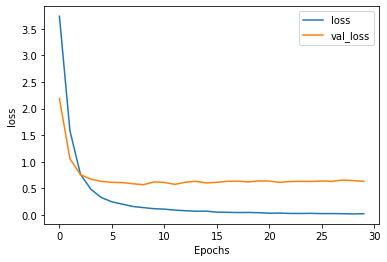

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [ ]:
class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_iii')
        
        self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))
        self.lstm_2 = layers.Bidirectional(layers.LSTM(256, dropout=0.2))
        self.rv_1 = layers.RepeatVector(3)
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.lstm_2(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
563/563 [==============================] - 26s 38ms/step - loss: 3.8237 - sparse_categorical_accuracy: 0.1119 - val_loss: 2.3410 - val_sparse_categorical_accuracy: 0.3271
Epoch 2/30
563/563 [==============================] - 21s 37ms/step - loss: 1.7365 - sparse_categorical_accuracy: 0.5021 - val_loss: 1.0880 - val_sparse_categorical_accuracy: 0.7131
Epoch 3/30
563/563 [==============================] - 21s 37ms/step - loss: 0.8772 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.7247 - val_sparse_categorical_accuracy: 0.8187
Epoch 4/30
563/563 [==============================] - 21s 37ms/step - loss: 0.5314 - sparse_categorical_accuracy: 0.8496 - val_loss: 0.6290 - val_sparse_categorical_accuracy: 0.8449
Epoch 5/30
563/563 [==============================] - 21s 37ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.5561 - val_sparse_categorical_accuracy: 0.8667
Epoch 6/30
563/563 [==============================] - 21s 37ms/step - loss: 0.3053 - spars

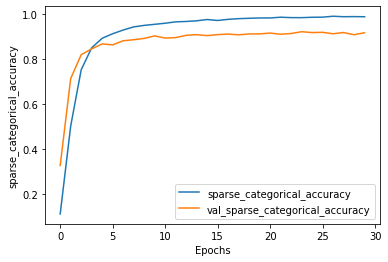

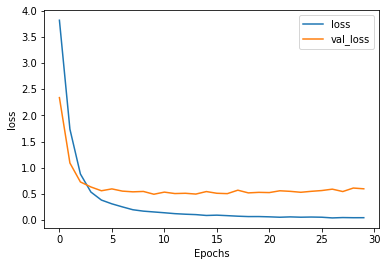

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")